In [4]:
from support_functions import *
from pedalboard import Chorus, Reverb, Distortion
import numpy as np
import tensorflow as tf
%matplotlib inline

dist = read_proces_dump('data/clean_guitar_large_sample.wav', 
                        'data/distortion_guitar_large_sample.wav', 
                 [Distortion(), Reverb(room_size=0.25)])

In [14]:
from keras import Sequential, Model
import keras.layers as layers
import tensorflow as tf

kernel_size=3  # <---- started with 3, from a https://github.com/GuitarML/GuitarLSTM/blob/main/train.py tried 12, but this lead to massive
               #       overfitting
chunk_size=1024

# Have not really played around with the layers, this 
# architecture is something roughly copied from a paper about
# selfsupervised learning 
model = Sequential(
    [
        layers.Conv1D(32, kernel_size=kernel_size, input_shape=(chunk_size,1), padding='same', activation='relu'),
        layers.Conv1D(32, kernel_size=kernel_size, padding='same', activation='relu'),
        layers.Conv1D(32, kernel_size=kernel_size, padding='same', activation='relu'),
        layers.MaxPooling1D(),

        layers.Conv1D(64, kernel_size=kernel_size, padding='same', activation='relu'),
        layers.Conv1D(64, kernel_size=kernel_size, padding='same', activation='relu'),
        layers.Conv1D(64, kernel_size=kernel_size, padding='same', activation='relu'),
        layers.MaxPooling1D(),
        
        layers.Conv1D(128, kernel_size=kernel_size, padding='same', activation='relu'),
        layers.Conv1D(128, kernel_size=kernel_size, padding='same', activation='relu'),
        layers.Conv1D(128, kernel_size=kernel_size, padding='same', activation='relu'),
        layers.MaxPooling1D(),

        layers.Conv1DTranspose(128, kernel_size=kernel_size, strides=2, padding='same', activation='relu'),
        layers.Conv1DTranspose(64, kernel_size=kernel_size, strides=2, padding='same', activation='relu'),
        layers.Conv1DTranspose(32, kernel_size=kernel_size, strides=2, padding='same', activation='relu'),
        layers.Conv1D(1, kernel_size=kernel_size, padding='same', activation='linear') # <---- needs to be linear and not relu to be able to generate negative numbers
    ]
)

opt = tf.keras.optimizers.Adam(learning_rate=0.00001)   # <---- Needs to be rather low to actually learn anything
model.compile(optimizer=opt, loss='mse')
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_40 (Conv1D)          (None, 1024, 32)          128       
                                                                 
 conv1d_41 (Conv1D)          (None, 1024, 32)          3104      
                                                                 
 conv1d_42 (Conv1D)          (None, 1024, 32)          3104      
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 512, 32)          0         
 g1D)                                                            
                                                                 
 conv1d_43 (Conv1D)          (None, 512, 64)           6208      
                                                                 
 conv1d_44 (Conv1D)          (None, 512, 64)           12352     
                                                      

(8041, 1024, 1)
(8041, 1024, 1)
Epoch 1/40
26/26 [==============================] - 2s 58ms/step - loss: 0.1021 - val_loss: 0.0984
Epoch 2/40
26/26 [==============================] - 1s 57ms/step - loss: 0.0928 - val_loss: 0.0879
Epoch 3/40
26/26 [==============================] - 1s 57ms/step - loss: 0.0819 - val_loss: 0.0765
Epoch 4/40
26/26 [==============================] - 1s 57ms/step - loss: 0.0716 - val_loss: 0.0675
Epoch 5/40
26/26 [==============================] - 1s 57ms/step - loss: 0.0640 - val_loss: 0.0614
Epoch 6/40
26/26 [==============================] - 1s 57ms/step - loss: 0.0586 - val_loss: 0.0563
Epoch 7/40
26/26 [==============================] - 1s 57ms/step - loss: 0.0535 - val_loss: 0.0510
Epoch 8/40
26/26 [==============================] - 1s 58ms/step - loss: 0.0479 - val_loss: 0.0450
Epoch 9/40
26/26 [==============================] - 1s 57ms/step - loss: 0.0417 - val_loss: 0.0386
Epoch 10/40
26/26 [==============================] - 1s 58ms/step - loss: 0.0

<AxesSubplot:xlabel='Epoch'>

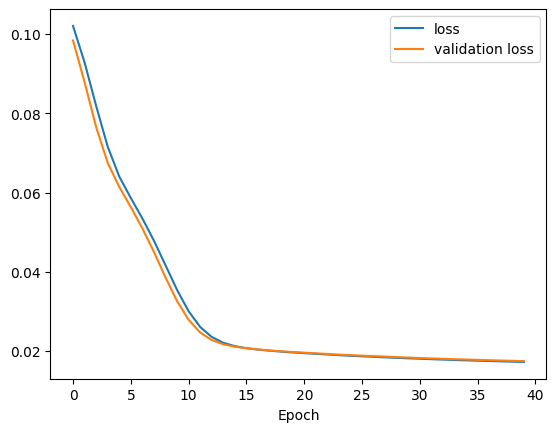

In [16]:
from tensorflow.keras.backend import clear_session

wav_length = len(dist)
max_multiple = wav_length - (wav_length % chunk_size)
original_chunked = dist['original'].to_numpy()[0:max_multiple].reshape((-1,chunk_size, 1))   
effected_chunked = dist['effected'].to_numpy()[0:max_multiple].reshape((-1,chunk_size, 1))
print(original_chunked.shape)
print(effected_chunked.shape)

from sklearn.model_selection import train_test_split

original_train, original_test, effected_train, effected_test = train_test_split(original_chunked, effected_chunked, test_size=0.2)
history = model.fit(original_train, effected_train, epochs=40, batch_size=256, validation_data=(original_test, effected_test))

plot_loss(history)

small clip to check the prediction:

32/32 [==============================] - 0s 14ms/step


<AxesSubplot:>

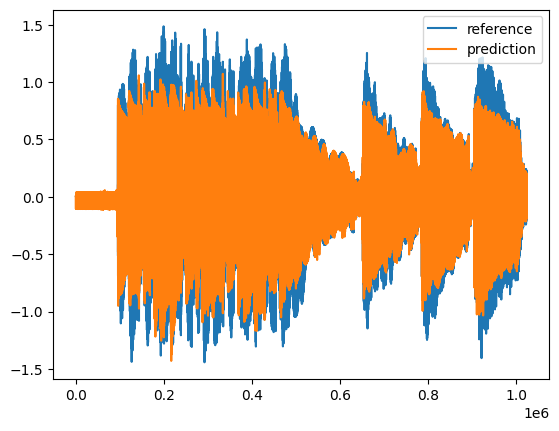

In [46]:
dist_show = dist.loc[:1000*chunk_size-1,]
orchu = dist_show['original'].to_numpy().reshape((-1,chunk_size, 1))   
effchu = dist_show['effected'].to_numpy().reshape((-1,chunk_size, 1))
effchu_pred = model.predict(np.resize(orchu, (orchu.size // chunk_size, chunk_size, 1))).flatten()
pd.DataFrame({'reference': effchu.flatten(), 'prediction': effchu_pred}).plot()

In [48]:
dump_numpy_audio(resize_to_mono(effchu_pred),
                 reference_wav='data/clean_guitar_large_sample.wav',
                 output_wav='data/trained_distortion_guitar_lstm.wav')
wav_player('data/trained_distortion_guitar_lstm.wav')

In [17]:
dump_numpy_audio(resize_to_mono(effected_signal[:max_pred_length]),
                 reference_wav='data/clean_guitar_large_sample.wav',
                 output_wav='data/trained_distortion_guitar_lstm.wav')
wav_player('data/trained_distortion_guitar_lstm.wav')

<ipython-input-17-3fd32d00796c>:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  dump_numpy_audio(resize_to_mono(effected_signal[:max_pred_length]),
